In [1]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## ``fvillena/spanish_diagnostics``

In [2]:
spanish_diagnostics = load_dataset('fvillena/spanish_diagnostics', revision='dev')

Found cached dataset parquet (/root/.cache/huggingface/datasets/fvillena___parquet/fvillena--spanish_diagnostics-0ca62ba96729c316/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
len(set(spanish_diagnostics["train"]["label"]))

48

In [4]:
train = spanish_diagnostics['train'].to_pandas()

In [5]:
test = spanish_diagnostics['test'].to_pandas()

In [6]:
validation = spanish_diagnostics["validation"].to_pandas()

In [7]:
len(train)

3401173

In [8]:
len(test)

971764

In [9]:
len(validation)

485882

In [10]:
df = (
    pd.concat(
        [
            train.label.value_counts(),
            test.label.value_counts(),
            validation.label.value_counts(),
        ],
        axis=1,
        keys=["train", "test", "validation"],
    )
    .reset_index()
    .melt(id_vars="label", var_name="subset", value_name="count")
)

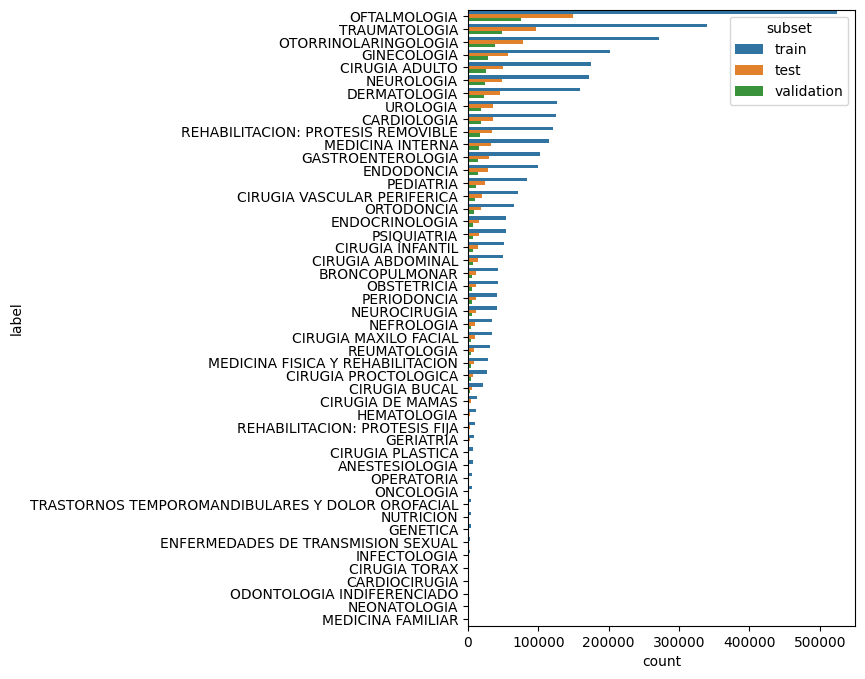

In [11]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.barplot(data=df, y="label", x="count", hue="subset", orient="h", ax=ax)
plt.show()

## ``plncmm/wl``

In [13]:
wl = load_dataset("plncmm/wl")

Found cached dataset wl (/root/.cache/huggingface/datasets/plncmm___wl/WL/1.1.0/b07c946a36b010338a23a04d73d526a61d5c0cdb0f76d9adf7702f306d87e246)


  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
labels = wl["train"].features[f"ner_tags"].feature.names

In [23]:
len(set([label.replace("B-","").replace("I-","") for label in labels if label != "O"]))

11

In [33]:
wl_train = wl['train'].to_pandas()

In [34]:
wl_test = wl['test'].to_pandas()

In [35]:
wl_validation = wl['validation'].to_pandas()

In [36]:
len(wl_train)

7987

In [37]:
len(wl_test)

987

In [38]:
len(wl_validation)

887

In [79]:
wl_label_description = (
    pd.concat(
        [
            wl_train.explode("ner_tags").ner_tags.value_counts(),
            wl_test.explode("ner_tags").ner_tags.value_counts(),
            wl_validation.explode("ner_tags").ner_tags.value_counts(),
        ],
        axis=1,
        keys=["train", "test", "validation"],
    )
    .reset_index()
    .melt(id_vars="ner_tags", var_name="subset", value_name="count")
)
wl_label_description = wl_label_description[
    wl_label_description.ner_tags != 0
]
wl_label_description["ner_tags"] = wl_label_description.ner_tags.map(lambda x: labels[x].replace('B-', '').replace('I-', ''))
wl_label_description = wl_label_description.groupby(["ner_tags","subset"]).sum().reset_index().sort_values(by=["count"], ascending=False)

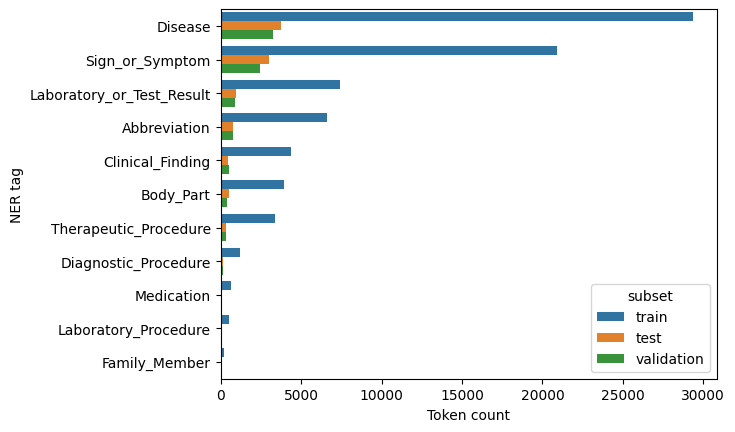

In [81]:
fig, ax = plt.subplots()
sns.barplot(data=wl_label_description, y="ner_tags", x="count", hue="subset", orient="h", ax=ax)
plt.ylabel("NER tag")
plt.xlabel("Token count")
plt.show()

## ``corpus_not_normalized``

In [1]:
from nltk.tokenize import word_tokenize
from multiprocessing import cpu_count
from math import ceil
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import Counter

In [2]:
N = 0
C = cpu_count()

In [3]:
corpus = []
with open("../data/raw/corpus_not_normalized.txt", "r", encoding="utf-8") as f:
    for line in f:
        corpus.append(line.strip())
        N += 1

In [4]:
BATCH_SIZE = ceil(N/C)

In [5]:
def process(batch, function):
    processed_batch = []
    for element in batch:
        processed_batch.append(function(element))
    return processed_batch

In [6]:
def execute_in_parallel(function, l, max_workers=C, batch_size=BATCH_SIZE):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        result = []
        futures = []
        for i in range(0, len(l), batch_size):
            batch = l[i:i + batch_size]
            futures.append(executor.submit(process, batch, function))
        for future in as_completed(futures):
            result.extend(future.result())
    return result


In [7]:
corpus = execute_in_parallel(word_tokenize, corpus)

In [8]:
counters = execute_in_parallel(Counter, corpus)

: 

: 